Zacinam trening navigacneho agenta s neuronovou sietou...
Velkost sveta: 10x10, Ciel: [9, 9], Max. krokov: 50
Vytvorena populacia s 500 jedincami
Vyhodnocujem pociatocnu populaciu...
Zacinam evoluciu - 200 generacii...
-- Generacia 1/200 --
  Min: 1.00, Max: 205.33, Priemer: 33.18, Odchylka: 38.80
-- Generacia 2/200 --
  Min: 1.00, Max: 205.33, Priemer: 43.40, Odchylka: 47.30
-- Generacia 3/200 --
  Min: 1.33, Max: 205.33, Priemer: 51.55, Odchylka: 56.62
-- Generacia 4/200 --
  Min: 1.00, Max: 205.33, Priemer: 61.51, Odchylka: 65.31
-- Generacia 5/200 --
  Min: 1.00, Max: 205.33, Priemer: 68.58, Odchylka: 75.63
-- Generacia 6/200 --
  Min: 1.00, Max: 205.67, Priemer: 89.21, Odchylka: 83.71
-- Generacia 7/200 --
  Min: 1.00, Max: 206.00, Priemer: 99.99, Odchylka: 88.25
-- Generacia 8/200 --
  Min: 2.67, Max: 207.00, Priemer: 109.21, Odchylka: 89.64
-- Generacia 9/200 --
  Min: 2.67, Max: 207.00, Priemer: 114.07, Odchylka: 89.31
-- Generacia 10/200 --
  Min: 3.33, Max: 207.00, Priemer: 1

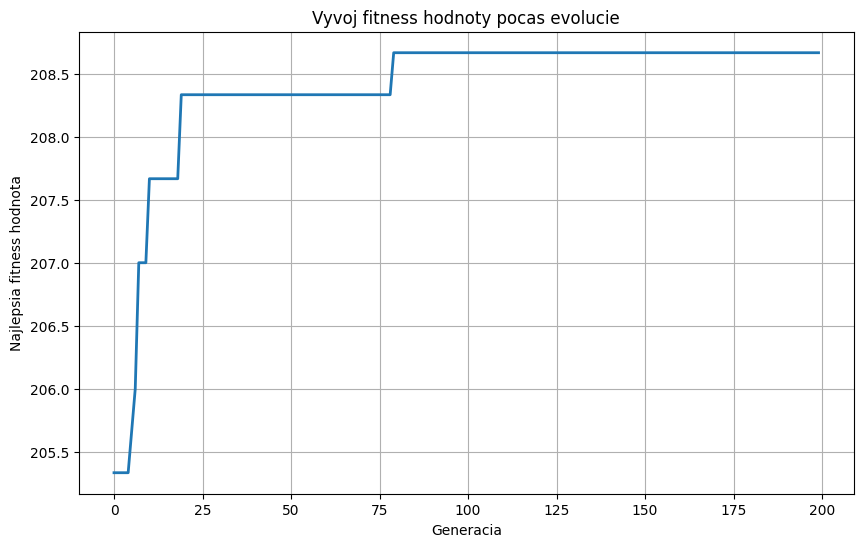


Vizualizujem spravanie najlepsieho agenta...


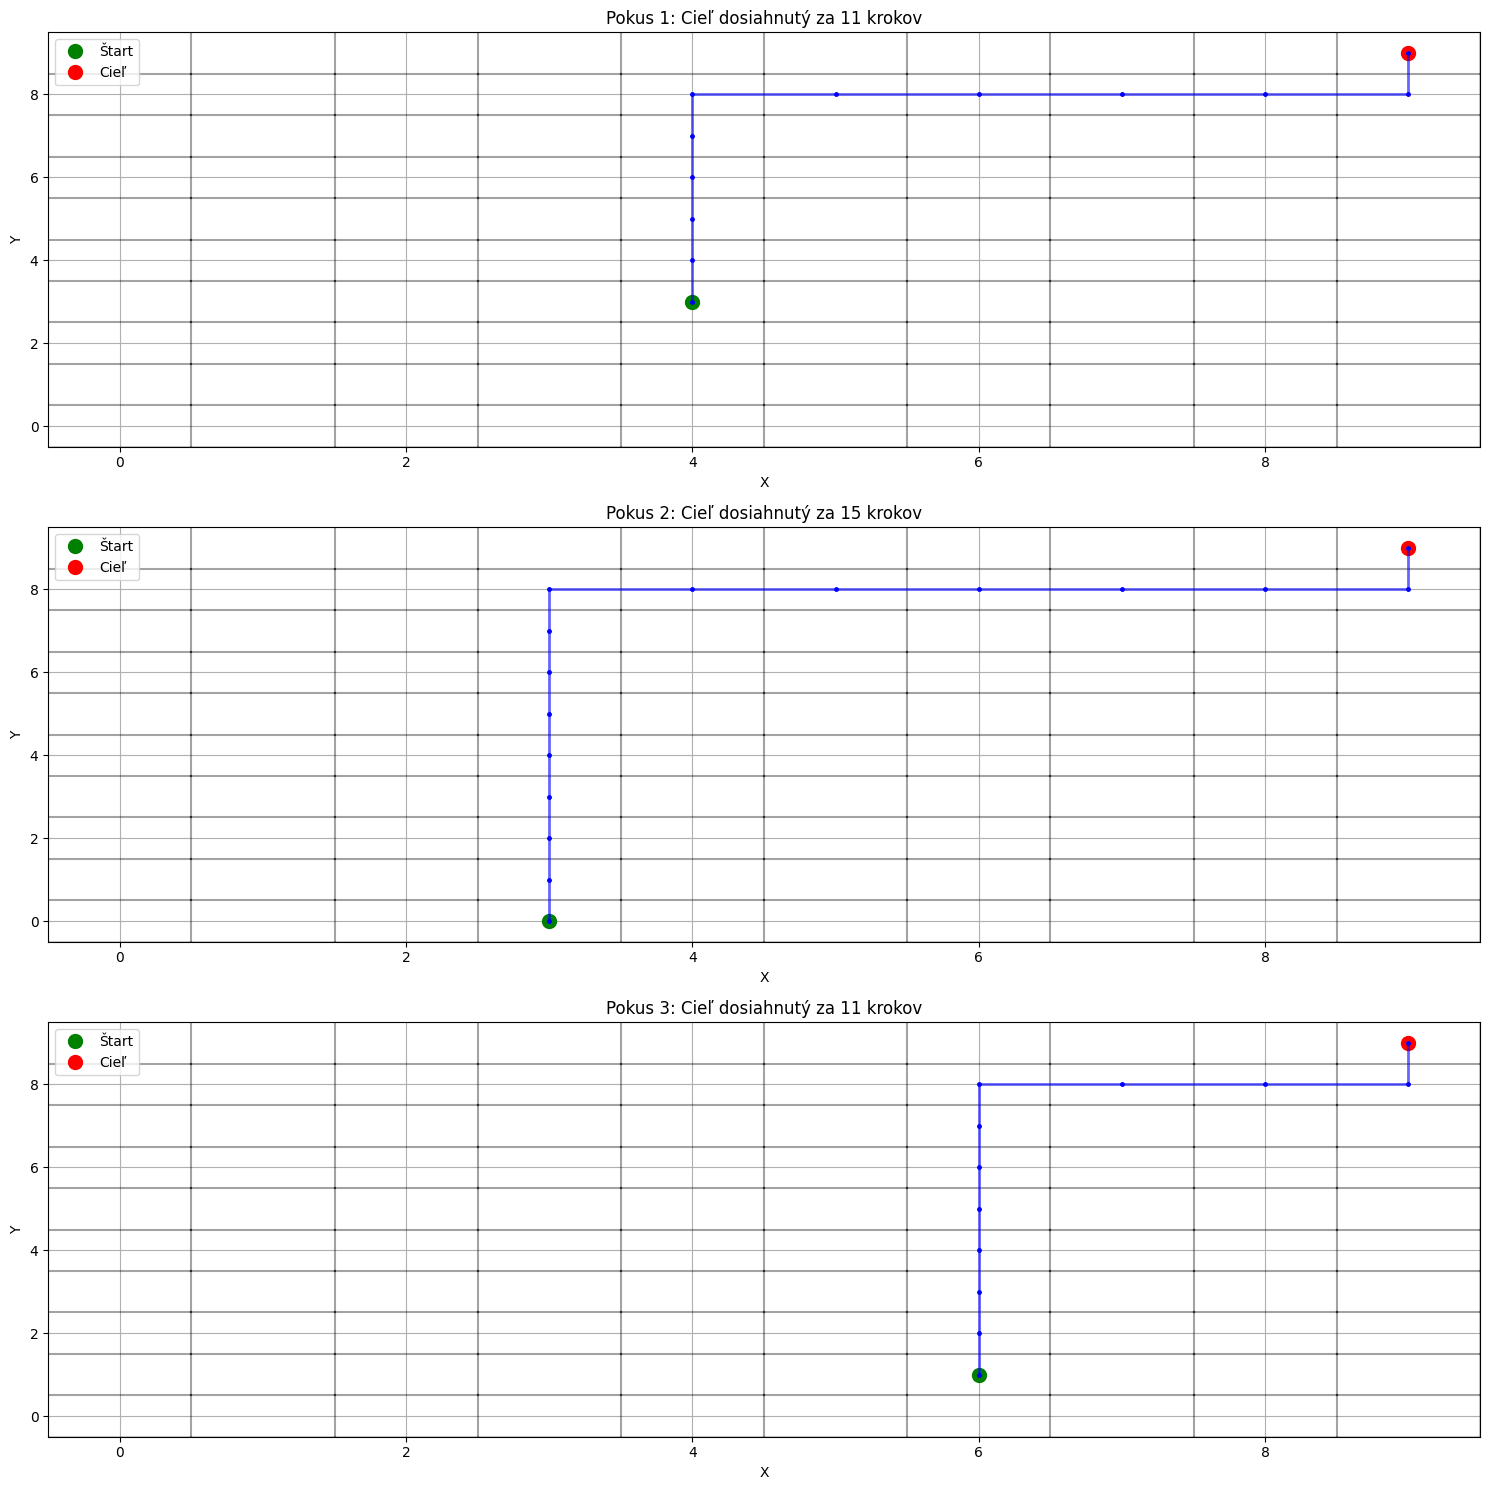

Hotovo! Agent uspesne natrenovany.


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms


# ==============================================================================
# NASTAVENIA PROSTREDIA
# ==============================================================================

WORLD_SIZE = 10         # Velkost stvorcovej mriezky sveta (10x10)
TARGET_POSITION = [9, 9]   # Cielova pozicia je v pravom dolnom rohu
MAX_STEPS = 50            # Maximalny pocet krokov povolenych na jedno kolo

# Nastavenia neuronovej siete
NUM_INPUTS = 5          # 5 senzorovych vstupov (4 smery k cielu + 1 rozsirena funkcia)
NUM_HIDDEN_NEURONS = 10  # 10 neuronov v skrytej vrstve
NUM_OUTPUTS = 4         # 4 vystupy (hore, dole, vlavo, vpravo)

# Vypocet celkoveho poctu vah v neuronovej sieti
GENOME_SIZE = (NUM_INPUTS * NUM_HIDDEN_NEURONS + NUM_HIDDEN_NEURONS +
               NUM_HIDDEN_NEURONS * NUM_OUTPUTS + NUM_OUTPUTS)

# ==============================================================================
# NASTAVENIA GENETICKEHO ALGORITMU
# ==============================================================================

POPULATION_SIZE = 500     # Pocet jedincov v populacii
MUTATION_PROB = 0.2         # Pravdepodobnost mutacie jedinca
GENE_MUTATION_PROB = 0.1    # Pravdepodobnost mutacie kazdeho genu
CROSSOVER_PROB = 0.7        # Pravdepodobnost krizenia dvoch jedincov
TOURNAMENT_SIZE = 5         # Velkost turnajoveho vyberu
NUM_ELITE_INDIVIDUALS = 20  # Pocet najlepsich jedincov, ktori sa zachovaju nezmeneni
MAX_GENERATIONS = 200   # Maximalny pocet generacii evolucie
NUM_GAME_ROUNDS = 3          # Pocet hernych kol na vyhodnotenie jedinca

# ==============================================================================
# VYMAZANIE EXISTUJUCICH TRIED DEAP (PREVENCIA KONFLIKTOV)
# ==============================================================================

if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# ==============================================================================
# VYTVORENIE ZAKLADNYCH TRIED PRE GENETICKY ALGORITMUS
# ==============================================================================

# Vytvorenie triedy fitnes s maximalizaciou (vyssia hodnota = lepsi jedinec)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# Vytvorenie triedy jedinca ako zoznamu genov s pridanou vlastnostou fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# ==============================================================================
# FUNKCIE PRE VNIMANIE PROSTREDIA A NAVIGACIU
# ==============================================================================

def sense_environment(position, target):
    """
    Vracia senzorove vstupy o prostredi pre agenta.
    
    Parametre:
        position: aktualna pozicia agenta [x, y]
        target: cielova pozicia [x, y]
        
    Vracia:
        zoznam senzorovych vstupov:
        - vzdialenosti k cielu v 4 smeroch (normalizovane)
        - normalizovana Manhattan vzdialenost k cielu
    """
    x, y = position
    target_x, target_y = target

    # 1-4. Vzdialenost k cielu v kazdom smere (normalizovana, blizsie = vyssia hodnota)
    distance_up = max(0, target_y - y) / WORLD_SIZE
    distance_down = max(0, y - target_y) / WORLD_SIZE
    distance_left = max(0, target_x - x) / WORLD_SIZE
    distance_right = max(0, x - target_x) / WORLD_SIZE

    # 5. Normalizovana Manhattan vzdialenost k cielu (blizsie = vyssia hodnota)
    manhattan_distance = (abs(x - target_x) + abs(y - target_y)) / (2 * WORLD_SIZE)
    target_proximity = 1 - manhattan_distance  # Inverzia: blizsie = vyssia hodnota

    return [
        1 - distance_up,    # Blizsie = vyssia hodnota
        1 - distance_down,
        1 - distance_left,
        1 - distance_right,
        target_proximity
    ]

# ==============================================================================
# NEURONOVA SIET
# ==============================================================================

def compute_neural_network(inputs, weights):
    """
    Vypocita vystup neuronovej siete pre dane vstupy a vahy.
    
    Parametre:
        inputs: vstupne hodnoty zo senzorov
        weights: genom (vahy neuronovej siete)
        
    Vracia:
        pravdepodobnosti pre jednotlive akcie
    """
    # Extrakcia vah z genomu pre jednotlive vrstvy
    input_hidden_weights = np.array(weights[:NUM_INPUTS * NUM_HIDDEN_NEURONS])
    input_hidden_weights = input_hidden_weights.reshape(NUM_INPUTS, NUM_HIDDEN_NEURONS)
    
    hidden_biases = np.array(weights[NUM_INPUTS * NUM_HIDDEN_NEURONS:
                                    NUM_INPUTS * NUM_HIDDEN_NEURONS + NUM_HIDDEN_NEURONS])
    
    hidden_output_weights = np.array(weights[NUM_INPUTS * NUM_HIDDEN_NEURONS + NUM_HIDDEN_NEURONS:-NUM_OUTPUTS])
    hidden_output_weights = hidden_output_weights.reshape(NUM_HIDDEN_NEURONS, NUM_OUTPUTS)
    
    output_biases = np.array(weights[-NUM_OUTPUTS:])

    # Vypocet skrytej vrstvy s ReLU aktivaciou
    hidden_layer = np.dot(inputs, input_hidden_weights) + hidden_biases
    hidden_layer = np.maximum(0, hidden_layer)

    # Vypocet vystupnej vrstvy
    output = np.dot(hidden_layer, hidden_output_weights) + output_biases

    # Aplikacia softmax pre ziskanie rozdelenia pravdepodobnosti
    exp_output = np.exp(output - np.max(output))
    probabilities = exp_output / exp_output.sum()

    return probabilities

# ==============================================================================
# FUNKCIA NAVIGACIE AGENTA
# ==============================================================================

def select_agent_move(agent_genome, input_values):
    """
    Urci pohyb agenta na zaklade vystupov neuronovej siete.
    
    Parametre:
        agent_genome: vahy neuronovej siete agenta
        input_values: senzorove vstupy z prostredia
        
    Vracia:
        move: 0=hore, 1=dole, 2=vlavo, 3=vpravo
    """
    action_probabilities = compute_neural_network(input_values, agent_genome)
    return np.argmax(action_probabilities)

# ==============================================================================
# SIMULACIA JEDNEHO KOLA HRY
# ==============================================================================

def simulate_game_round(agent_genome, start_position=None):
    """
    Simuluje jedno kolo hry pre agenta.
    
    Parametre:
        agent_genome: genom agenta (vahy neuronovej siete)
        start_position: volitelna startovacia pozicia (nahodna ak None)
        
    Vracia:
        tuple: (skore, pocet_krokov, dosiahol_ciel)
    """
    if start_position is None:
        position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
    else:
        position = start_position.copy()

    if position == TARGET_POSITION:
        return simulate_game_round(agent_genome)

    step_count = 0
    visited_positions = []
    target_reached = False

    while step_count < MAX_STEPS and not target_reached:
        input_values = sense_environment(position, TARGET_POSITION)
        selected_move = select_agent_move(agent_genome, input_values)
        
        visited_positions.append(tuple(position))
        
        new_position = position.copy()
        
        if selected_move == 0 and position[1] < WORLD_SIZE-1:    # Hore
            new_position[1] += 1
        elif selected_move == 1 and position[1] > 0:             # Dole
            new_position[1] -= 1
        elif selected_move == 2 and position[0] > 0:             # Vlavo
            new_position[0] -= 1
        elif selected_move == 3 and position[0] < WORLD_SIZE-1:  # Vpravo
            new_position[0] += 1
        
        position = new_position
        
        if position == TARGET_POSITION:
            target_reached = True
        
        step_count += 1
        
        if visited_positions.count(tuple(position)) > 2:
            break

    if target_reached:
        base_score = MAX_STEPS * 2
        speed_bonus = MAX_STEPS - step_count
        score = base_score + speed_bonus
    else:
        distance_to_target = abs(position[0] - TARGET_POSITION[0]) + abs(position[1] - TARGET_POSITION[1])
        max_distance = WORLD_SIZE * 2
        score = max(0, max_distance - distance_to_target)
        
        loop_penalty = sum(visited_positions.count(p) - 1 for p in set(visited_positions))
        score = max(1, score - loop_penalty)

    return score, step_count, target_reached

# ==============================================================================
# FUNKCIA VYPOCTU FITNESS
# ==============================================================================

def compute_population_fitness(agent_population):
    """
    Vypocita fitness pre zoznam agentov na zaklade viacerých kol hry.
    
    Parametre:
        agent_population: zoznam genomov agentov
        
    Vracia:
        zoznam hodnot fitness ako n-tice
    """
    fitness_values = []

    for agent_genome in agent_population:
        total_score = 0
        target_reach_count = 0
        
        for _ in range(NUM_GAME_ROUNDS):
            start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
            while start_position == TARGET_POSITION:
                start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
            
            score, steps, target_reached = simulate_game_round(agent_genome, start_position)
            
            total_score += score
            if target_reached:
                target_reach_count += 1
        
        avg_score = total_score / NUM_GAME_ROUNDS
        final_fitness = avg_score + (target_reach_count * 20)
        
        fitness_values.append((final_fitness,))

    return fitness_values

# ==============================================================================
# INICIALIZACIA NASTROJOV PRE GENETICKY ALGORITMUS
# ==============================================================================

toolbox = base.Toolbox()

toolbox.register("generate_gene", random.uniform, -1, 1)
toolbox.register("generate_individual", tools.initRepeat, creator.Individual,
                 toolbox.generate_gene, n=GENOME_SIZE)
toolbox.register("generate_population", tools.initRepeat, list, toolbox.generate_individual)

toolbox.register("evaluate", lambda individual: compute_population_fitness([individual])[0])
toolbox.register("crossover", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.3, indpb=GENE_MUTATION_PROB)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

stats = tools.Statistics(lambda individual: individual.fitness.values)
stats.register("priemer", np.mean)
stats.register("minimum", np.min)
stats.register("maximum", np.max)
stats.register("std_odchylka", np.std)

# ==============================================================================
# VIZUALIZACIA NAJLEPSIEHO AGENTA
# ==============================================================================

def display_best_agent(agent_genome, num_attempts=3):
    """
    Vizualizuje spravanie najlepsieho agenta v mriezkovom svete.
    
    Parametre:
        agent_genome: genom (vahy) najlepsieho agenta
        num_attempts: pocet pokusov na vizualizaciu
    """
    plt.figure(figsize=(15, 5*num_attempts))

    for attempt in range(num_attempts):
        start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
        while start_position == TARGET_POSITION:
            start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
        
        position = start_position.copy()
        path = [position.copy()]
        step_count = 0
        target_reached = False
        
        while step_count < MAX_STEPS and not target_reached:
            input_values = sense_environment(position, TARGET_POSITION)
            selected_move = select_agent_move(agent_genome, input_values)
            
            new_position = position.copy()
            if selected_move == 0 and position[1] < WORLD_SIZE-1:
                new_position[1] += 1
            elif selected_move == 1 and position[1] > 0:
                new_position[1] -= 1
            elif selected_move == 2 and position[0] > 0:
                new_position[0] -= 1
            elif selected_move == 3 and position[0] < WORLD_SIZE-1:
                new_position[0] += 1
            
            position = new_position
                
            path.append(position.copy())
            
            if position == TARGET_POSITION:
                target_reached = True
                
            step_count += 1
        
        plt.subplot(num_attempts, 1, attempt+1)
        plt.grid(True)
        plt.xlim(-0.5, WORLD_SIZE-0.5)
        plt.ylim(-0.5, WORLD_SIZE-0.5)
        
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                plt.plot([i-0.5, i+0.5], [j-0.5, j-0.5], 'k-', alpha=0.2)
                plt.plot([i-0.5, i-0.5], [j-0.5, j+0.5], 'k-', alpha=0.2)
                plt.plot([i+0.5, i+0.5], [j-0.5, j+0.5], 'k-', alpha=0.2)
                plt.plot([i-0.5, i+0.5], [j+0.5, j+0.5], 'k-', alpha=0.2)
        
        plt.plot(start_position[0], start_position[1], 'go', markersize=10, label='Štart')
        plt.plot(TARGET_POSITION[0], TARGET_POSITION[1], 'ro', markersize=10, label='Cieľ')
        
        path_x = [point[0] for point in path]
        path_y = [point[1] for point in path]
        plt.plot(path_x, path_y, 'b-', linewidth=2, alpha=0.6)
        plt.plot(path_x, path_y, 'b.', markersize=5)
        
        plt.title(f'Pokus {attempt+1}: {"Cieľ dosiahnutý" if target_reached else "Neúspešný"} za {len(path)-1} krokov')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()

    plt.tight_layout()
    plt.show()

# ==============================================================================
# HLAVNA FUNKCIA
# ==============================================================================

if __name__ == "__main__":
    print("Zacinam trening navigacneho agenta s neuronovou sietou...")
    print(f"Velkost sveta: {WORLD_SIZE}x{WORLD_SIZE}, Ciel: {TARGET_POSITION}, Max. krokov: {MAX_STEPS}")
    
    population = toolbox.generate_population(n=POPULATION_SIZE)
    print(f"Vytvorena populacia s {POPULATION_SIZE} jedincami")

    print("Vyhodnocujem pociatocnu populaciu...")
    fitness_values = compute_population_fitness(population)
    for individual, fitness in zip(population, fitness_values):
        individual.fitness.values = fitness

    hall_of_fame = tools.HallOfFame(NUM_ELITE_INDIVIDUALS)
    hall_of_fame.update(population)

    fitness_history = []
    generation_history = []

    print(f"Zacinam evoluciu - {MAX_GENERATIONS} generacii...")
    for generation in range(MAX_GENERATIONS):
        print(f"-- Generacia {generation + 1}/{MAX_GENERATIONS} --")
        
        offspring = toolbox.select(population, len(population) - NUM_ELITE_INDIVIDUALS)
        offspring = list(map(toolbox.clone, offspring))
        
        for i in range(0, len(offspring), 2):
            if i+1 < len(offspring) and random.random() < CROSSOVER_PROB:
                offspring[i], offspring[i+1] = toolbox.crossover(offspring[i], offspring[i+1])
                del offspring[i].fitness.values
                del offspring[i+1].fitness.values
        
        for i in range(len(offspring)):
            if random.random() < MUTATION_PROB:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values
        
        elite_individuals = toolbox.clone(tools.selBest(population, NUM_ELITE_INDIVIDUALS))
        
        individuals_to_evaluate = [individual for individual in offspring if not individual.fitness.valid]
        fitness_values = compute_population_fitness(individuals_to_evaluate)
        for individual, fitness in zip(individuals_to_evaluate, fitness_values):
            individual.fitness.values = fitness
        
        population[:] = offspring + elite_individuals
        
        hall_of_fame.update(population)
        
        record = stats.compile(population)
        print(f"  Min: {record['minimum']:.2f}, Max: {record['maximum']:.2f}, Priemer: {record['priemer']:.2f}, Odchylka: {record['std_odchylka']:.2f}")
        
        generation_history.append(generation)
        fitness_history.append(record['maximum'])

    best_individual = tools.selBest(population, 1)[0]

    print("\n=== Najlepsi jedinec ===")
    print(f"Fitness hodnota: {best_individual.fitness.values[0]:.2f}")
    print(f"Trening dokonceny po {MAX_GENERATIONS} generaciach.")

    plt.figure(figsize=(10, 6))
    plt.plot(generation_history, fitness_history, linewidth=2)
    plt.xlabel('Generacia')
    plt.ylabel('Najlepsia fitness hodnota')
    plt.title('Vyvoj fitness hodnoty pocas evolucie')
    plt.grid(True)
    plt.show()

    print("\nVizualizujem spravanie najlepsieho agenta...")
    display_best_agent(best_individual)
    
    print("Hotovo! Agent uspesne natrenovany.")